In [18]:
import pandas as pd
import tensorflow as tf
import numpy as np
import statsmodels.tsa.api as tsa
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import xgboost as xgb
from datetime import datetime,timedelta

# 一二问

In [2]:
# 附录1中A的数据
Spot_A_FirstPrediction = pd.read_excel("/home/competition/math_modeling/questions/B/1.xlsx",sheet_name="监测点A逐小时污染物浓度与气象一次预报数据")
Spot_A_RealTimeData = pd.read_excel("/home/competition/math_modeling/questions/B/1.xlsx",sheet_name="监测点A逐小时污染物浓度与气象实测数据")
Spot_A_RealTimeData_ByDay = pd.read_excel("/home/competition/math_modeling/questions/B/1.xlsx",sheet_name='监测点A逐日污染物浓度实测数据')
Appendix1 = [Spot_A_FirstPrediction,Spot_A_RealTimeData,Spot_A_RealTimeData_ByDay]
# 附录2中B的数据
Spot_B_FirstPrediction = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name="监测点B逐小时污染物浓度与气象一次预报数据")
Spot_B_RealTimeData = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name="监测点B逐小时污染物浓度与气象实测数据")
Spot_B_RealTimeData_ByDay = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name='监测点B逐日污染物浓度实测数据')
# 附录2中C的数据
Spot_C_FirstPrediction = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name="监测点C逐小时污染物浓度与气象一次预报数据")
Spot_C_RealTimeData = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name="监测点C逐小时污染物浓度与气象实测数据")
Spot_C_RealTimeData_ByDay = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name='监测点C逐日污染物浓度实测数据')
# 其中C有一个列名不同，进行修改
Spot_C_RealTimeData_ByDay.rename(columns={'实测日期':"监测日期"},inplace=True)

<font size=20 color ='red'><center> 目前未处理缺失值！！！！！！</font></center>

In [3]:
Spot_A_FirstPrediction.head()

,模型运行日期,预测时间,地点,近地2米温度（℃）,地表温度（K）,比湿（kg/kg）,湿度（%）,近地10米风速（m/s）,近地10米风向（°）,雨量（mm）,...,潜热通量（W/m²）,长波辐射（W/m²）,短波辐射（W/m²）,地面太阳能辐射（W/m²）,SO2小时平均浓度(μg/m³),NO2小时平均浓度(μg/m³),PM10小时平均浓度(μg/m³),PM2.5小时平均浓度(μg/m³),O3小时平均浓度(μg/m³),CO小时平均浓度(mg/m³)
0,2020-07-23,2020-07-23 00:00:00,监测点A,29.8890,304.016,0.018870,66.7409,4.16382,162.577,0.000000,...,0.94818,428.278,0.0,0.0,2.401510,20.9208,8.17336,5.27729,8.78723,0.124491
1,2020-07-23,2020-07-23 01:00:00,监测点A,29.8736,303.739,0.017556,62.1551,4.65267,171.978,0.000000,...,1.14987,427.531,0.0,0.0,1.448340,14.8144,6.49054,4.33106,12.74530,0.109056
2,2020-07-23,2020-07-23 02:00:00,监测点A,29.6471,303.419,0.017874,64.1760,4.10031,172.013,0.000000,...,1.01616,427.428,0.0,0.0,1.271610,13.9154,6.86679,4.40045,12.22960,0.105957
3,2020-07-23,2020-07-23 03:00:00,监测点A,29.4555,303.419,0.018935,68.7958,2.44317,168.135,0.047224,...,1.89003,442.472,0.0,0.0,0.467429,11.1535,5.25900,3.35261,13.78000,0.101764
4,2020-07-23,2020-07-23 04:00:00,监测点A,28.5189,302.987,0.019881,76.5791,2.57759,207.884,8.260020,...,6.53753,458.394,0.0,0.0,0.574856,13.9989,6.05979,3.59303,9.96333,0.104536


In [4]:
for i in Appendix1:
    for column in i.columns:
        if i[column].isna().sum()!=0:
            print("列名    {}    ，缺失值数量{}".format(column,i[column].isna().sum()))

列名    SO2监测浓度(μg/m³)    ，缺失值数量7
列名    NO2监测浓度(μg/m³)    ，缺失值数量9
列名    PM10监测浓度(μg/m³)    ，缺失值数量14
列名    PM2.5监测浓度(μg/m³)    ，缺失值数量8
列名    O3最大八小时滑动平均监测浓度(μg/m³)    ，缺失值数量10
列名    CO监测浓度(mg/m³)    ，缺失值数量9


In [5]:
Spot_A_RealTimeData['地点'].describe()

count     19432
unique        1
top        监测点A
freq      19432
Name: 地点, dtype: object

In [6]:
# clustering
## 对污染情况、气象条件进行进行聚类
## 其中的缺失值用—表示，先剔除有缺失值的样本
## 目标是对气象情况进行聚类，将其分为若干不同类
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()


In [7]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
print(metrics.silhouette_score(X, labels, metric='euclidean'))


/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.577156299076908


/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


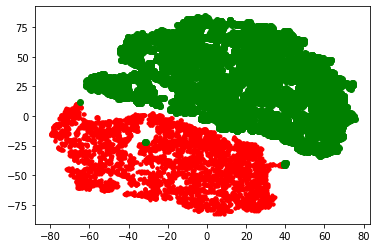

In [8]:
# 降维示意图
tsne = TSNE()
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
plt.plot(d1[0], d1[1], 'r.', d2[0], d2[1], 'go')
plt.show()

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


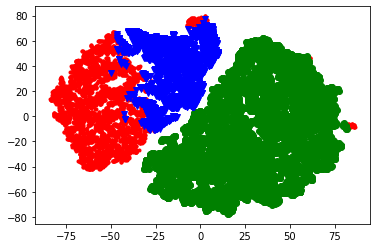

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4411399438299433


In [9]:
# 分为3类
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()
kmeans = KMeans(n_clusters=3, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
tsne = TSNE()
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
d3 = liris[kmeans_matrix['labels'] == 2]
plt.plot(d1[0], d1[1], 'r.', d2[0], d2[1], 'go',d3[0],d3[1],"bv")
plt.show()
print(metrics.silhouette_score(X, labels, metric='euclidean'))

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


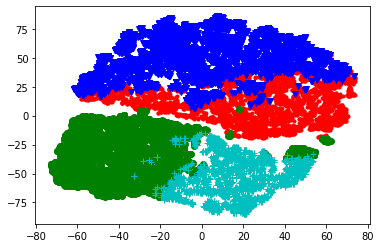

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2665146707446006


In [10]:
# 分为四类
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()
kmeans = KMeans(n_clusters=4, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
tsne = TSNE()
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
d3 = liris[kmeans_matrix['labels'] == 2]
d4 = liris[kmeans_matrix['labels'] == 3]
plt.plot(d1[0], d1[1], 'r.', d2[0], d2[1], 'go',d3[0],d3[1],"bv",d4[0],d4[1],"c+")
plt.show()
print(metrics.silhouette_score(X, labels, metric='euclidean'))

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


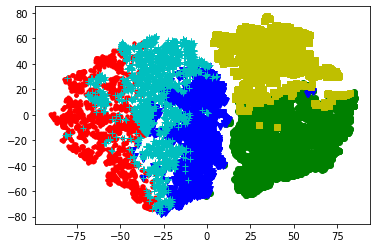

In [11]:
# 分为5类
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()
kmeans = KMeans(n_clusters=5, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
tsne = TSNE()
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
d3 = liris[kmeans_matrix['labels'] == 2]
d4 = liris[kmeans_matrix['labels'] == 3]
d5 = liris[kmeans_matrix['labels'] == 4]
plt.plot(d1[0], d1[1], 'r.', d2[0], d2[1], 'go',d3[0],d3[1],"bv",d4[0],d4[1],"c+",d5[0],d5[1],"ys")
plt.show()

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


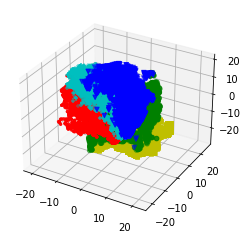

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.23140896341656925


In [12]:
# 分为5类 3维展示
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()
kmeans = KMeans(n_clusters=5, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
tsne = TSNE(n_components=3)
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
d3 = liris[kmeans_matrix['labels'] == 2]
d4 = liris[kmeans_matrix['labels'] == 3]
d5 = liris[kmeans_matrix['labels'] == 4]
for d,c,m in [(d1,"r","."),(d2,'g','o'),(d3,'b','v'),(d4,'c','+'),(d5,'y','s')]:
    ax.scatter(d[0],d[1],d[2],c =c,marker = m)
plt.show()
print(metrics.silhouette_score(X, labels, metric='euclidean'))

In [13]:
# 基于k = 5时的kmeans分析
# 先使用随机产生的数据作为AQI进行分析
# Attention:其中的label是气象类别
# 可对其进行回归等分析
X[X['labels']==1].var()/X[X['labels']==1].mean()# 变异系数
X['Fake_AQI'] = np.random.randint(50,300,X.shape[0])


In [14]:
#回归
X_svm = X.drop(['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)','Fake_AQI'],axis = 1)
X_svm['labels'] = LabelEncoder().fit_transform(X_svm['labels'])
y_svm = X['Fake_AQI']
train_X,test_X,train_y,test_y = train_test_split(X_svm,
                                                    y_svm,
                                                    test_size=0.2)

regr = svm.SVR()
regr.fit(train_X, train_y)



SVR()

# 三四部分
第三问题目中要求模型对各地点均适用，因此可以假设在相同的天气和污染情况下，各地的AQI相差不大

目前思路：处理完成数据后，使用xgboost进行拟合,其中只需要表1与表2，易得表3可以通过表二得出

自变量中，若想预测$t$时刻的$Y$，可以将$t$时刻的预测值与$t-1$时刻的观测值纳入

In [15]:
# 时间处理
for i in [Spot_A_FirstPrediction,Spot_B_FirstPrediction,Spot_C_FirstPrediction]:
    i['模型运行日期'] = pd.to_datetime(i['模型运行日期'])
    i['预测时间'] = pd.to_datetime(i['预测时间'])
for j in [Spot_A_RealTimeData,Spot_B_RealTimeData,Spot_C_RealTimeData]:
    j['监测时间'] = pd.to_datetime(j['监测时间'])
for i in [Spot_A_RealTimeData_ByDay,Spot_B_RealTimeData_ByDay,Spot_C_RealTimeData_ByDay]:
    i['监测日期'] = pd.to_datetime(i['监测日期'])


In [47]:
Spot_A_FirstPrediction_temp = Spot_A_FirstPrediction.copy()
Spot_A_FirstPrediction_temp['预测时间'] = Spot_A_FirstPrediction_temp["预测时间"] - timedelta(hours=1)
Spot_A_RealTimeData_temp = Spot_A_RealTimeData.copy()
Spot_A_RealTimeData_temp.merge(Spot_A_FirstPrediction_temp,left_on='监测时间',right_on='预测时间')
Spot_A_Train_Data = Spot_A_RealTimeData_temp.merge(Spot_A_FirstPrediction_temp,left_on='监测时间',right_on='预测时间')
Spot_A_RealTimeData_temp = Spot_A_RealTimeData.copy()
Spot_A_RealTimeData_temp['监测时间'] = Spot_A_RealTimeData_temp["监测时间"] - timedelta(hours=1)
Spot_A_Train_Data = Spot_A_Train_Data.merge(Spot_A_RealTimeData_temp[['监测时间',
                                                                        'SO2监测浓度(μg/m³)',
                                                                        'NO2监测浓度(μg/m³)',
                                                                        'PM10监测浓度(μg/m³)',
                                                                        'PM2.5监测浓度(μg/m³)',
                                                                        'O3监测浓度(μg/m³)',
                                                                        'CO监测浓度(mg/m³)']],left_on="监测时间",right_on='监测时间')
Spot_A_Train_Data.head()

,监测时间,地点_x,SO2监测浓度(μg/m³)_x,NO2监测浓度(μg/m³)_x,PM10监测浓度(μg/m³)_x,PM2.5监测浓度(μg/m³)_x,O3监测浓度(μg/m³)_x,CO监测浓度(mg/m³)_x,温度(℃),湿度(%),...,PM10小时平均浓度(μg/m³),PM2.5小时平均浓度(μg/m³),O3小时平均浓度(μg/m³),CO小时平均浓度(mg/m³),SO2监测浓度(μg/m³)_y,NO2监测浓度(μg/m³)_y,PM10监测浓度(μg/m³)_y,PM2.5监测浓度(μg/m³)_y,O3监测浓度(μg/m³)_y,CO监测浓度(mg/m³)_y
0,2020-07-22 23:00:00,监测点A,4,14,8,6,22,0.5,29.9,73,...,8.17336,5.27729,8.78723,0.124491,4,12,3,3,23,0.4
1,2020-07-23 00:00:00,监测点A,4,12,3,3,23,0.4,29.7,74,...,6.49054,4.33106,12.74530,0.109056,3,11,3,1,24,0.4
2,2020-07-23 01:00:00,监测点A,3,11,3,1,24,0.4,29.3,76,...,6.86679,4.40045,12.22960,0.105957,4,13,14,2,20,0.4
3,2020-07-23 02:00:00,监测点A,4,13,14,2,20,0.4,29.1,79,...,5.25900,3.35261,13.78000,0.101764,4,12,12,1,20,0.4
4,2020-07-23 03:00:00,监测点A,4,12,12,1,20,0.4,29,80,...,6.05979,3.59303,9.96333,0.104536,4,13,7,-2,18,0.4


In [48]:
Spot_B_FirstPrediction_temp = Spot_B_FirstPrediction.copy()
Spot_B_FirstPrediction_temp['预测时间'] = Spot_B_FirstPrediction_temp["预测时间"] - timedelta(hours=1)
Spot_B_RealTimeData_temp = Spot_B_RealTimeData.copy()
Spot_B_RealTimeData_temp.merge(Spot_B_FirstPrediction_temp,left_on='监测时间',right_on='预测时间')
Spot_B_Train_Data = Spot_B_RealTimeData_temp.merge(Spot_B_FirstPrediction_temp,left_on='监测时间',right_on='预测时间')
Spot_B_RealTimeData_temp = Spot_B_RealTimeData.copy()
Spot_B_RealTimeData_temp['监测时间'] = Spot_B_RealTimeData_temp["监测时间"] - timedelta(hours=1)
Spot_B_Train_Data = Spot_B_Train_Data.merge(Spot_B_RealTimeData_temp[['监测时间',
                                                                        'SO2监测浓度(μg/m³)',
                                                                        'NO2监测浓度(μg/m³)',
                                                                        'PM10监测浓度(μg/m³)',
                                                                        'PM2.5监测浓度(μg/m³)',
                                                                        'O3监测浓度(μg/m³)',
                                                                        'CO监测浓度(mg/m³)']],left_on="监测时间",right_on='监测时间')
Spot_B_Train_Data.head()

,监测时间,地点_x,SO2监测浓度(μg/m³)_x,NO2监测浓度(μg/m³)_x,PM10监测浓度(μg/m³)_x,PM2.5监测浓度(μg/m³)_x,O3监测浓度(μg/m³)_x,CO监测浓度(mg/m³)_x,温度(℃),湿度(%),...,PM10小时平均浓度(μg/m³),PM2.5小时平均浓度(μg/m³),O3小时平均浓度(μg/m³),CO小时平均浓度(mg/m³),SO2监测浓度(μg/m³)_y,NO2监测浓度(μg/m³)_y,PM10监测浓度(μg/m³)_y,PM2.5监测浓度(μg/m³)_y,O3监测浓度(μg/m³)_y,CO监测浓度(mg/m³)_y
0,2020-07-22 23:00:00,监测点B,9,9,14,5,40,0.4,29,88,...,4.23814,2.13777,25.8596,0.076385,9,9,14,5,36,0.4
1,2020-07-23 00:00:00,监测点B,9,9,14,5,36,0.4,28.9,88,...,4.56836,2.40459,24.6701,0.075857,8,8,8,4,33,0.4
2,2020-07-23 01:00:00,监测点B,8,8,8,4,33,0.4,28.8,89,...,5.06645,2.67897,23.4993,0.076176,8,10,11,5,30,0.4
3,2020-07-23 02:00:00,监测点B,8,10,11,5,30,0.4,28.6,90,...,5.66022,2.98245,21.3877,0.076902,9,11,12,5,26,0.4
4,2020-07-23 03:00:00,监测点B,9,11,12,5,26,0.4,28.3,92,...,7.23576,3.88890,17.4381,0.078260,9,14,12,5,20,0.4


In [50]:
Spot_C_FirstPrediction_temp = Spot_C_FirstPrediction.copy()
Spot_C_FirstPrediction_temp['预测时间'] = Spot_C_FirstPrediction_temp["预测时间"] - timedelta(hours=1)
Spot_C_RealTimeData_temp = Spot_C_RealTimeData.copy()
Spot_C_RealTimeData_temp.merge(Spot_C_FirstPrediction_temp,left_on='监测时间',right_on='预测时间')
Spot_C_Train_Data = Spot_C_RealTimeData_temp.merge(Spot_C_FirstPrediction_temp,left_on='监测时间',right_on='预测时间')
Spot_C_RealTimeData_temp = Spot_C_RealTimeData.copy()
Spot_C_RealTimeData_temp['监测时间'] = Spot_C_RealTimeData_temp["监测时间"] - timedelta(hours=1)
Spot_C_Train_Data = Spot_C_Train_Data.merge(Spot_C_RealTimeData_temp[['监测时间',
                                                                        'SO2监测浓度(μg/m³)',
                                                                        'NO2监测浓度(μg/m³)',
                                                                        'PM10监测浓度(μg/m³)',
                                                                        'PM2.5监测浓度(μg/m³)',
                                                                        'O3监测浓度(μg/m³)',
                                                                        'CO监测浓度(mg/m³)']],left_on="监测时间",right_on='监测时间')
Spot_C_Train_Data.head()

,监测时间,地点_x,SO2监测浓度(μg/m³)_x,NO2监测浓度(μg/m³)_x,PM10监测浓度(μg/m³)_x,PM2.5监测浓度(μg/m³)_x,O3监测浓度(μg/m³)_x,CO监测浓度(mg/m³)_x,温度(℃),湿度(%),...,PM10小时平均浓度(μg/m³),PM2.5小时平均浓度(μg/m³),O3小时平均浓度(μg/m³),CO小时平均浓度(mg/m³),SO2监测浓度(μg/m³)_y,NO2监测浓度(μg/m³)_y,PM10监测浓度(μg/m³)_y,PM2.5监测浓度(μg/m³)_y,O3监测浓度(μg/m³)_y,CO监测浓度(mg/m³)_y
0,2020-07-22 23:00:00,监测点C,8,32,NaN,17,137,0.637,31.9,63,...,30.1491,23.5952,0.000002,0.276276,9,41,21,16,60,0.596
1,2020-07-23 00:00:00,监测点C,9,41,21,16,60,0.596,31.7,62,...,28.7767,22.0022,0.110509,0.372511,10,47,8,14,23,0.567
2,2020-07-23 01:00:00,监测点C,10,47,8,14,23,0.567,31.1,63,...,26.5221,19.0562,5.015980,0.305093,14,51,NaN,18,14,0.637
3,2020-07-23 02:00:00,监测点C,14,51,NaN,18,14,0.637,30.4,68,...,18.1417,12.0180,11.161400,0.240851,14,46,38,18,13,0.572
4,2020-07-23 03:00:00,监测点C,14,46,38,18,13,0.572,30.1,70,...,17.6025,10.9584,9.063650,0.226328,11,34,21,19,15,0.492


In [51]:
Spot_Data_train = pd.concat([Spot_C_Train_Data,
                            Spot_C_Train_Data,
                            Spot_C_Train_Data])

In [52]:
Spot_Data_train.head()


,监测时间,地点_x,SO2监测浓度(μg/m³)_x,NO2监测浓度(μg/m³)_x,PM10监测浓度(μg/m³)_x,PM2.5监测浓度(μg/m³)_x,O3监测浓度(μg/m³)_x,CO监测浓度(mg/m³)_x,温度(℃),湿度(%),...,PM10小时平均浓度(μg/m³),PM2.5小时平均浓度(μg/m³),O3小时平均浓度(μg/m³),CO小时平均浓度(mg/m³),SO2监测浓度(μg/m³)_y,NO2监测浓度(μg/m³)_y,PM10监测浓度(μg/m³)_y,PM2.5监测浓度(μg/m³)_y,O3监测浓度(μg/m³)_y,CO监测浓度(mg/m³)_y
0,2020-07-22 23:00:00,监测点C,8,32,NaN,17,137,0.637,31.9,63,...,30.1491,23.5952,0.000002,0.276276,9,41,21,16,60,0.596
1,2020-07-23 00:00:00,监测点C,9,41,21,16,60,0.596,31.7,62,...,28.7767,22.0022,0.110509,0.372511,10,47,8,14,23,0.567
2,2020-07-23 01:00:00,监测点C,10,47,8,14,23,0.567,31.1,63,...,26.5221,19.0562,5.015980,0.305093,14,51,NaN,18,14,0.637
3,2020-07-23 02:00:00,监测点C,14,51,NaN,18,14,0.637,30.4,68,...,18.1417,12.0180,11.161400,0.240851,14,46,38,18,13,0.572
4,2020-07-23 03:00:00,监测点C,14,46,38,18,13,0.572,30.1,70,...,17.6025,10.9584,9.063650,0.226328,11,34,21,19,15,0.492
